# Prepare range offset for co-seismic deformation

```bash
# Sentinel-1 asc. track 99, May 20 - 26, 2021
cuDenseOffsets.py ... --ww 128 --wh 64  --oo 64 --kw 20 --kh 6 --sw 8 --sh 8 --raw-osf 2 --redo --outprefix offset1

# Sentinel-1 desc. track 106, May 20 - 26, 2021
cuDenseOffsets.py ... --ww 128 --wh 128 --oo 64 --kw 20 --kh 6 --sw 8 --sh 8 --raw-osf 2 --redo --outprefix offset3
```

In [2]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from mintpy.objects import deramp
from mintpy.utils import readfile, writefile, plot as pp, isce_utils, utils as ut, attribute as attr
from mintpy import view, geocode, spatial_filter
from tools.offset_mask_filter import fill_offset_rubber_sheeting
plt.rcParams.update({'font.size': 12})

SNWE = (33.2, 35.9, 96.6, 100.1)  # output bounding box in lat/lon

# file for range offset [high resolution due to small window size]
#off_file = os.path.expanduser('~/data/archives/2021MaduoEQ/SenAT099/merged/offsets/20210520_20210526/offset1.bip')  # asc.
off_file = os.path.expanduser('~/data/archives/2021MaduoEQ/SenDT106/merged/offsets/20210520_20210526/offset3.bip')  # desc.
rdr_file = os.path.join(os.path.dirname(off_file), 'rgOff.h5')

# geom file
proj_dir = os.path.abspath(os.path.join(off_file, '../../../..'))
geom_dir = os.path.join(os.path.dirname(off_file), 'geom{}'.format(off_file[-5]))
lat_file = os.path.join(geom_dir, 'lat.rdr')
lon_file = os.path.join(geom_dir, 'lon.rdr')
los_file = os.path.join(geom_dir, 'los.rdr')
msk_file = os.path.join(geom_dir, 'waterMask.rdr')
water_mask = readfile.read(msk_file)[0]

# aux file
fbase = os.path.splitext(off_file)[0]
cov_file = fbase + '_cov.bip'
snr_file = fbase + '_snr.bip'
dem_file = os.path.join(proj_dir, '../DEM/demLat_N33_N36_Lon_E096_E101.dem')

## 1. Mask offset (and save in HDF5 format)

extract metadata from ISCE/topsStack xml file: /Users/yunjunz/data/archives/2021MaduoEQ/SenDT106/merged/offsets/20210520_20210526/../../../reference/IW1.xml
Slant range pixel size: 2.33 m
delete exsited file: /Users/yunjunz/data/archives/2021MaduoEQ/SenDT106/merged/offsets/20210520_20210526/rgOff.h5
create HDF5 file: /Users/yunjunz/data/archives/2021MaduoEQ/SenDT106/merged/offsets/20210520_20210526/rgOff.h5 with w mode
create dataset /displacement    of float32    in size of (3737, 3412)         with compression=lzf
create dataset /displacementStd of float32    in size of (3737, 3412)         with compression=lzf
add /displacement    attribute: UNIT = m
add /displacementStd attribute: UNIT = m
finished writing to /Users/yunjunz/data/archives/2021MaduoEQ/SenDT106/merged/offsets/20210520_20210526/rgOff.h5
view.py /Users/yunjunz/data/archives/2021MaduoEQ/SenDT106/merged/offsets/20210520_20210526/rgOff.h5 displacement -v -1 1 --flip-lr --nosearch --figsize 15 12 --noverbose


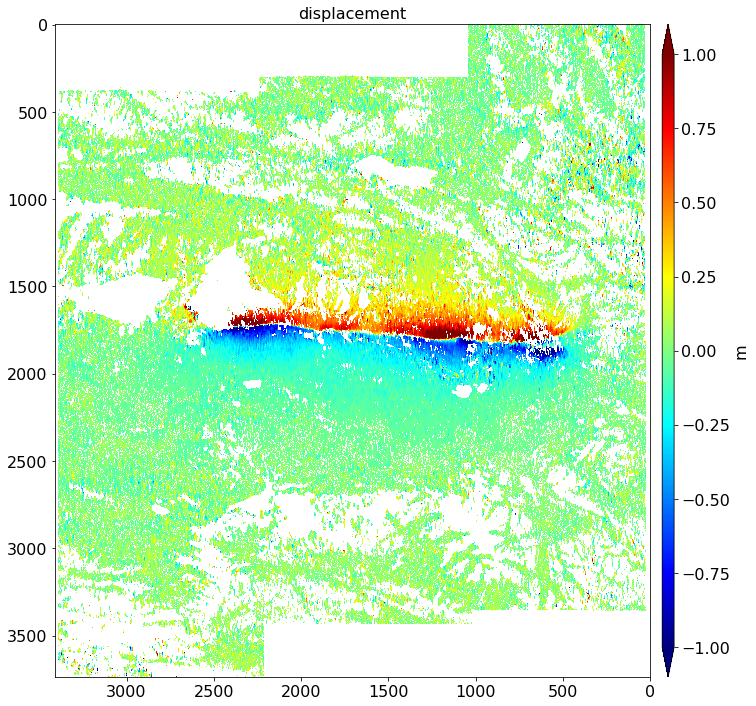

In [17]:
# read data / attribute
off, atr  = readfile.read(off_file, datasetName='rangeOffset')
off_std   = np.sqrt(readfile.read(cov_file, datasetName='range')[0])

# convert offset unit from pixel to meters
xml_file = os.path.join(os.path.dirname(off_file), '../../../reference/IW1.xml')
meta = isce_utils.extract_isce_metadata(xml_file, update_mode=False)[0]
pixel_size = float(meta['RANGE_PIXEL_SIZE'])
print('Slant range pixel size: {:.2f} m'.format(pixel_size))
off *= pixel_size
off_std *= pixel_size
# remote abnormal values
off[np.abs(off) > 2] = np.nan
off_std[np.isnan(off)] = np.nan

## massking
# ignore zero value
off[off == 0] = np.nan
# ignore water body
off[water_mask == 0] = np.nan
# skip pixels with SNR < 5
off_snr = readfile.read(snr_file)[0]
off[np.isnan(off_snr)] = np.nan
off[off_snr < 5] = np.nan
# skip pixels with STD < 15 cm
off[off_std > 0.15] = np.nan

# write to one HDF5 files
ds_dict = {'displacement' : np.array(off, dtype=np.float32), 'displacementStd' : np.array(off_std, dtype=np.float32)}
ds_unit_dict = {'displacement' : 'm', 'displacementStd' : 'm'}
writefile.write(ds_dict, out_file=rdr_file, metadata=atr, ds_unit_dict=ds_unit_dict, compression='lzf')
view.main(f'{rdr_file} displacement -v -1 1 --flip-lr --nosearch --figsize 15 12 --noverbose'.split())

## 2. Geocode [to ISCE-2 format]

No lookup table info range/lat found in files.
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /Users/yunjunz/data/archives/2021MaduoEQ/SenDT106/merged/offsets/20210520_20210526/geom3/lat.rdr
output pixel size in (lat, lon) in degree: (-0.000462963, 0.000462963)
output area extent in (S, N, W, E) in degree: (33.199999784, 35.9, 96.6, 100.10000027999999)
output file row / column number: (5832, 7560)
searching relevant box covering the current SNWE
--------------------------------------------------
resampling file: /Users/yunjunz/data/archives/2021MaduoEQ/SenDT106/merged/offsets/20210520_20210526/rgOff.h5
--------------------------------------------------
reading displacement in block (0, 0, 3411, 3736) from rgOff.h5 ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 45 segments ...
write file: /Users/yunjunz/data/archives/2021MaduoEQ/SenDT106/merged/offsets/20210520_20210526/rgOff.geo
write file: /Users

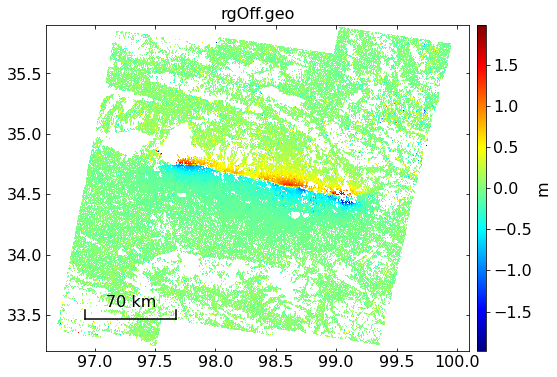

No lookup table info range/lat found in files.
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /Users/yunjunz/data/archives/2021MaduoEQ/SenDT106/merged/offsets/20210520_20210526/geom3/lat.rdr
output pixel size in (lat, lon) in degree: (-0.000462963, 0.000462963)
output area extent in (S, N, W, E) in degree: (33.199999784, 35.9, 96.6, 100.10000027999999)
output file row / column number: (5832, 7560)
searching relevant box covering the current SNWE
--------------------------------------------------
resampling file: /Users/yunjunz/data/archives/2021MaduoEQ/SenDT106/merged/offsets/20210520_20210526/rgOff.h5
--------------------------------------------------
reading displacementStd in block (0, 0, 3411, 3736) from rgOff.h5 ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 45 segments ...
write file: /Users/yunjunz/data/archives/2021MaduoEQ/SenDT106/merged/offsets/20210520_20210526/rgOffStd.geo
write file: 

In [21]:
# geocode
S, N, W, E = SNWE
step = 0.000462963  # deg for 50 m
opt = f' --bbox {S} {N} {W} {E} --lalo -{step} {step} --lat-file {lat_file} --lon-file {lon_file}'

geo_file = '{}.geo'.format(os.path.splitext(rdr_file)[0])
cmd = f'{rdr_file} --dset displacement -o {geo_file} {opt}'
geocode.main(cmd.split())
view.main([f'{geo_file}'])

out_file = '{}Std.geo'.format(os.path.splitext(rdr_file)[0])
cmd = f'{rdr_file} --dset displacementStd -o {out_file} {opt}'
geocode.main(cmd.split())

out_file = '{}.geo'.format(os.path.splitext(los_file)[0])
cmd = f'{los_file} -o {out_file} {opt}'
geocode.main(cmd.split())

## 3. Plot

run view.py in MintPy version v1.3.2-29, date 2022-02-03
input file is isce .bip file: /Users/yunjunz/data/archives/2021MaduoEQ/SenDT106/merged/offsets/20210520_20210526/rgOff.geo in float32 format
file size in y/x: (5832, 7560)
num of datasets in file rgOff.geo: 1
datasets to exclude (0):
[]
datasets to display (1):
['band1']
data   coverage in y/x: (0, 0, 7560, 5832)
subset coverage in y/x: (0, 0, 7560, 5832)
data   coverage in lat/lon: (96.6, 35.9, 100.10000028, 33.199999784)
subset coverage in lat/lon: (96.6, 35.9, 100.10000028, 33.199999784)
------------------------------------------------------------------------
area exceed 2000 pixels, turn off default DEM contour display
colormap: RdBu
initiate cartopy map projection: PlateCarree
figure title: rgOff.geo
figure size : [9.72, 6.00]
reading data ...
data    range: [-1.9837677, 1.9837677] m
display range: [-1.0, 1.0] m
reading DEM: demLat_N33_N36_Lon_E096_E101.dem ...
display data in transparency: 0.8
plot in geo-coordinate
plottin

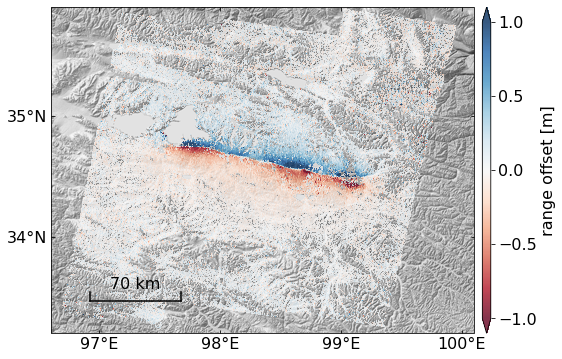

In [24]:
cmd = f'{geo_file} --dem {dem_file} -v -1 1 -c RdBu --notitle '
cmd += ' --notitle --lalo-label --cbar-nbins 5 '
view.main(cmd.split() + ['--cbar-label', 'range offset [m]'])